In [707]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import pdist, squareform

from IPython.display import Javascript
from string import Template

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import OPTICS, FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

import altair as alt
alt.renderers.enable("default")
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

In [437]:
%%HTML
    <script src="https://d3js.org/d3.v5.min.js"></script>

In [438]:
%%javascript
    var script = document.createElement('script');
    script.type = 'text/javascript';
    script.src = '//d3js.org/d3.v5.min.js';
    document.head.appendChild(script);
    console.log(window.d3)

<IPython.core.display.Javascript object>

In [659]:
auto_dataset = pd.read_csv("data/auto_mpg.csv")
auto_df = auto_dataset.drop("car name", axis=1)

In [661]:
auto_df = auto_df.replace({"?":np.nan})
imputer = SimpleImputer()
auto_df = pd.DataFrame(imputer.fit_transform(auto_df), columns = auto_df.columns)

In [522]:
bike_dataset = pd.read_csv("data/bike.csv")
bike_df = bike_dataset.drop(["instant", "casual", "registered", "workingday", "dteday"], axis=1)

#de-normalize data to produce human-readable features.
#Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
bike_df["hum"] = bike_df["hum"].apply(lambda x: x*100.)
bike_df["windspeed"] = bike_df["windspeed"].apply(lambda x: x*67.)
#convert Celsius to Fahrenheit
bike_df["temp"] = bike_df["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
bike_df["atemp"] = bike_df["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

bike_df = pd.get_dummies(bike_df, prefix=["weathersit"], columns=["weathersit"], drop_first = True)

#rename features to make them interpretable for novice users
bike_feature_names_dict = {
    "cnt":"Ridership",
    "yr":"First or Second Year", 
    "season":"Season", 
    "mnth": "Month",
    "hr":"Hour of Day", 
    "holiday":"Holiday",
    "weekday":"Week Day",
    "weathersit_2":"Misty Weather",
    "weathersit_3":"Light Precipitation",
    "weathersit_4":"Heavy Precipitation",
    "temp":"Temperature (F)",
    "atemp":"Feels Like (F)",
    "hum":"Humidity",
    "windspeed":"Wind Speed"
}
bike_df = bike_df.rename(mapper=bike_feature_names_dict,axis=1) 

In [449]:
breast_cancer_columns = pd.read_table("data/breast_cancer_field_names.txt", names=["features"])["features"].tolist()
breast_cancer_dataset = pd.read_csv("data/breast_cancer.csv", names=breast_cancer_columns)
breast_cancer_df = breast_cancer_dataset.drop("ID", axis=1)
breast_cancer_df["diagnosis"] = np.where(
    breast_cancer_df["diagnosis"] == "M",
    1,
    0
)

In [2]:
boston_dataset = datasets.load_boston()
boston_df = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
boston_df["Median_Home_Value"] = boston_dataset.target*1000.

In [84]:
cancer_dataset = pd.read_csv("data/cervical_cancer.csv")
cancer_df = cancer_dataset.drop("Person", axis=1)

In [352]:
cancer_age_corrected_df = cancer_df.copy()
cancer_age_corrected_df["Smokes (years)"] = cancer_age_corrected_df["Smokes (years)"]/cancer_age_corrected_df["Age"]
cancer_age_corrected_df["Hormonal Contraceptives (years)"] = cancer_age_corrected_df["Hormonal Contraceptives (years)"]/cancer_age_corrected_df["Age"]
cancer_age_corrected_df["IUD (years)"] = cancer_age_corrected_df["IUD (years)"]/cancer_age_corrected_df["Age"]
cancer_age_corrected_df["Num of pregnancies"] = cancer_age_corrected_df["Num of pregnancies"]/(cancer_age_corrected_df["Age"])

In [792]:
def visualize_feature_correlation(data, chart_type, target_name = None, corr_threshold = 0.7):
    df = data.copy()
    corr = np.round(df.corr(),2)
    if target_name is not None:
        target_corr = np.abs(corr.rename({target_name:"target_corr"}, axis=1)["target_corr"])
        df = df.drop(target_name, axis=1)
        corr = corr.drop(target_name, axis=1).drop(target_name, axis=0)
    feature_order = sorted(list(df.columns))
    if chart_type == "SPLOM":
        chart = alt.Chart(df).mark_circle().encode(
            alt.X(alt.repeat("column"), type='quantitative'),
            alt.Y(alt.repeat("row"), type='quantitative')
        ).properties(
            width=100,
            height=100
        ).repeat(
            row=list(df.columns),
            column=list(df.columns)
        )
        return chart
    elif chart_type == "dendrogram":
#     corr_condensed = hc.distance.squareform(1 - np.abs(cancer_df.corr()) ) # convert to condensed
#     z = hc.linkage(corr_condensed, method='average')
#     dendrogram_order = hc.dendrogram(z, labels=cancer_df.columns)["ivl"]      
        fig = ff.create_dendrogram(
            1 - np.abs(corr), 
            labels = df.columns
        )
        fig.update_layout(width=800, height=500)
        fig.show()
    elif chart_type == "punchcard":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis=None),
            y = alt.Y("variable", sort = feature_order, axis=None)
        ).transform_calculate(
            abs_val = 'abs(datum.value)',
            positive_corr = 'datum.value > 0'
        ).transform_lookup(
            lookup='index',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_X", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_X']
            )
        ).transform_lookup(
            lookup='variable',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_Y", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_Y']
            )
        ).properties(
            width = 700,
            height = 500
        )

        circles = base.mark_circle().encode(
            color = "positive_corr:N",
            size = alt.condition(
                "datum.order_Y >= datum.order_X",
                alt.value(0),
                alt.Size(
                    "abs_val:Q", 
                    scale=alt.Scale(range=[0,2000], domain=[0,1])
                )
            )
        )
        text = base.mark_text(align="right").encode(
            text = "index",
            opacity = alt.condition("datum.order_Y == datum.order_X", alt.value(1), alt.value(0))
        )
        return (text+circles).resolve_scale(y = "shared", x="shared")
    elif chart_type == "heatmap":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis = alt.Axis(labelAngle=15)),
            y = alt.Y("variable", sort = feature_order)
        ).transform_calculate(
            abs_val = 'abs(datum.value)'
        ).properties(
            width = 700,
            height = 500
        )

        rects = base.mark_rect().encode(
            color = alt.Color("abs_val:Q", scale=alt.Scale(domain=[0,1])),
        )
        text = base.mark_text(align="center").encode(
            text = "value",
            color = alt.condition(
                "datum.value < .5",
                alt.value("black"),
                alt.value("white")
            )
        )
        return (rects+text).resolve_scale(y = "shared", x="shared")
    elif chart_type == "clusters":
        
        #compute PCA and store as X,Y coordinates for each feature
        #pca = KernelPCA(n_components = 2, kernel="cosine")
        pca = PCA(n_components = 2)
        pca.fit(np.abs(corr))
        #print(pca.explained_variance_ratio_)
        pca_coords = pd.DataFrame.from_dict(
            dict(
                zip(
                    list(df.columns),
                    pca.transform(np.abs(corr)).tolist()
                )
            ),
            orient="index"
        ).reset_index().rename({0:"X", 1:"Y", "index":"Feature"}, axis=1)
        
        #get feature clusters via another method
        #corr_clusters = DBSCAN(eps=0.75, metric="precomputed", min_samples=1).fit(1 - np.abs(cancer_df.drop("Biopsy", axis=1).corr()))
        #corr_clusters = OPTICS(max_eps=1, metric="precomputed", min_samples=2).fit(1 - np.abs(corr))
        #corr_clusters = FeatureAgglomeration(n_clusters = 5, affinity = "precomputed", linkage = "average").fit(1 - np.abs(corr))
        scaler = StandardScaler()
        feature_distances = squareform(pdist(scaler.fit_transform(df).T, "euclidean"))
        silhouette_scores = []
        #for n_cluster in range(2,df.shape[1]):
        for n_cluster in range(3,10):
            corr_clusters = FeatureAgglomeration(n_clusters = n_cluster, affinity = "precomputed", linkage = "average").fit(feature_distances)
            #corr_clusters = FeatureAgglomeration(n_clusters = n_cluster, linkage = "average").fit(scaler.fit_transform(df))
            silhouette_scores.append(
                (
                    n_cluster,
                    silhouette_score(feature_distances, corr_clusters.labels_, metric = "precomputed"),
                    #silhouette_score(scaler.fit_transform(df).T, corr_clusters.labels_, metric = "euclidean"),
                    corr_clusters.labels_
                )
            )
                
        #return silhouette_scores
        silhouette_scores.sort(key = lambda x: x[1], reverse = True)
        labels = silhouette_scores[0][2]
            
        #corr_clusters = FeatureAgglomeration(n_clusters = 5, linkage = "average").fit(scaler.fit_transform(df))
        cluster_label_df = pd.DataFrame.from_dict(
            dict(
                list(
                    zip(
                        df.columns,
                        #corr_clusters.labels_
                        labels
                    )
                )
            ),
            orient="index"
        ).rename({0:"Cluster"}, axis=1)
        
        pca_coords = pca_coords.set_index("Feature").join(
            cluster_label_df
        )
        
        # set correlation with target, if using, which determines circle size
        if target_name is not None:
            pca_coords = pca_coords.join(
                target_corr
            ).reset_index()
        else:
            pca_coords = pca_coords.reset_index()
            pca_coords["target_corr"] = 1
            
        # get dataset for lines between features (if they have higher correlation than corr_threshold)
        corr_lines = corr.reset_index(drop=False).rename({"index":"Feature"}, axis=1)\
            .melt(id_vars = ["Feature"], var_name = "Feature_2", value_name = "corr")\
            .query("corr >= @corr_threshold and Feature > Feature_2")
        corr_lines_1 = pd.merge(
            corr_lines, 
            pca_coords.loc[:,["Feature", "X", "Y"]], 
            on = "Feature"
        )
        corr_lines_2 = pd.merge(
            corr_lines, 
            pca_coords.set_index("Feature").loc[:,["X", "Y"]],
            left_on = "Feature_2", right_index = True
        )
        corr_lines = corr_lines_1.append(corr_lines_2)
        corr_lines["key"] = corr_lines["Feature"] + corr_lines["Feature_2"]
        corr_lines = corr_lines.drop(["Feature", "Feature_2", "corr"], axis=1)
        
        base = alt.layer().encode(
            x = "X",
            y = "Y"
        )
        
        base += alt.Chart(pca_coords).mark_circle().encode(
            color = alt.Color("Cluster:N"),
            size = alt.Size("target_corr:Q", scale=alt.Scale(domain = [0,1]))
        )
        
        base += alt.Chart(pca_coords).mark_text(dx=20, dy = 10).encode(
            color = alt.Color("Cluster:N"),
            text = "Feature",
        )
        
        base += alt.Chart(corr_lines).mark_line().encode(
            detail = "key"
        )
        
        return base.properties(width = 800, height = 500).interactive()
        
        
#         base = alt.Chart(pca_coords).encode(
#             x = "X",
#             y = "Y",
#             color = alt.Color("Cluster:N")
#         )

#         points = base.mark_point().encode(
#             size = alt.Size("target_corr:Q", scale=alt.Scale(domain = [0,1]))
#         )
#         text = base.mark_text(dx=20, dy = 10).encode(
#             text = "Feature"
#         )
#         lines = alt.Chart(corr_lines).mark_line().encode(
#             x = alt.X("X", scale = alt.Scale(domain = [np.min(pca_coords.X), np.max(pca_coords.X)])),
#             y = alt.X("Y", scale = alt.Scale(domain = [np.min(pca_coords.Y), np.max(pca_coords.Y)])),
#             detail = "key"
#         )
#         return (points+text+lines).interactive()
    elif chart_type == "force_layout":
        chart_data = {
            "nodes": [{"id": x} for x in list(corr.index)],
            "links": [
                {
                    "source": x["index"],
                    "target": x["variable"],
                    "value": abs(x["value"])
                }
                for x in corr.reset_index(drop = False).melt(id_vars="index").to_dict("records")
                if x["index"] > x["variable"] and abs(x["value"])> 0.5
            ]
        }
        d3_script = Template("""

        var margin = {top: 10, right: 30, bottom: 30, left: 30},
            width = 960 - margin.left - margin.right,
            height = 500 - margin.top - margin.bottom;

          var data = $data
          const links = data.links.map(d => Object.create(d));
          const nodes = data.nodes.map(d => Object.create(d));

          const simulation = d3.forceSimulation(nodes)
              .force("link", d3.forceLink(links).id(d => d.id).distance(100).strength(d => Math.pow(d.value,2)))
              .force("charge", d3.forceManyBody().strength(-50).distanceMax(350))
              .force("center", d3.forceCenter(width / 2, height / 2));

        var svg = d3.select(element).append("svg")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
          .append("g")
            .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

          const link_objects = svg.append("g")
              .attr("stroke", "#999")
              .attr("stroke-opacity", 0.6)
            .selectAll("line")
            .data(links)
            .join("line")
              .attr("stroke-width", d => Math.sqrt(d.value));

          const node_objects = svg
            .selectAll(".node")
            .data(nodes)
            .join("g")
              .attr("class", "node")
            
          node_objects.append("circle")
            .attr("r", 5)
            .attr("fill", "blue");
            
        
          node_objects.append("text")
            .text(d => d.id);

          simulation.on("tick", () => {
            link_objects
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node_objects
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);
          });

          //invalidation.then(() => simulation.stop());
        """)

        return Javascript(d3_script.substitute(data=chart_data))

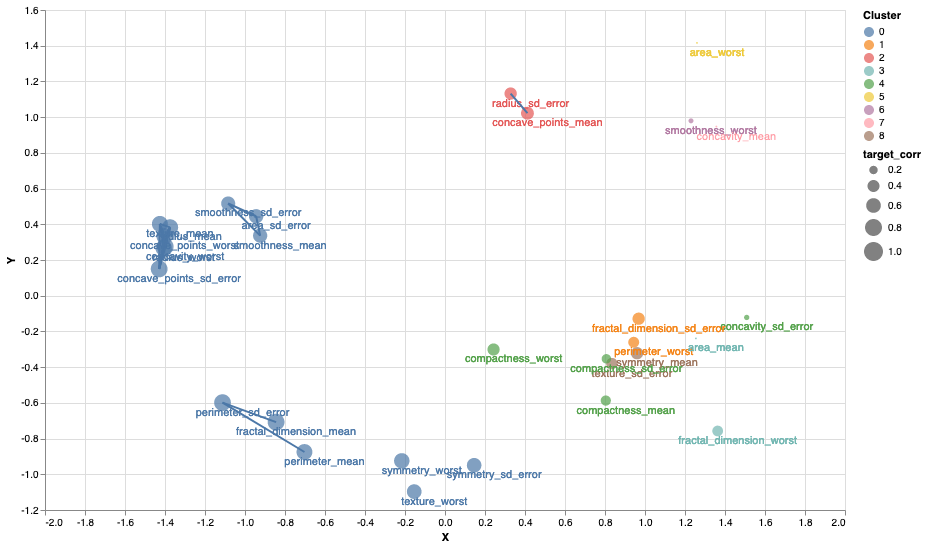

In [797]:
visualize_feature_correlation(breast_cancer_df, "clusters", "diagnosis", .9)

In [735]:
boston_distances = pd.DataFrame(visualize_feature_correlation(boston_df, "clusters", None, .5), columns = boston_df.columns)

In [736]:
1 - (boston_distances / np.max(boston_distances.max()))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Median_Home_Value
0,1.000000,0.176273,0.420855,0.227466,0.427919,0.169856,0.395148,0.116929,0.539923,0.514378,0.366490,0.115205,0.445300,0.114170
1,0.176273,1.000000,0.068900,0.232308,0.074143,0.376402,0.058124,0.564475,0.138875,0.138017,0.113095,0.317350,0.106328,0.398762
2,0.420855,0.068900,1.000000,0.272234,0.634503,0.113095,0.551918,0.017449,0.521628,0.602720,0.409577,0.124222,0.526778,0.084234
3,0.227466,0.232308,0.272234,1.000000,0.283294,0.283313,0.281449,0.211791,0.245426,0.234930,0.203822,0.266760,0.228184,0.317243
4,0.427919,0.074143,0.634503,0.283294,1.000000,0.142084,0.610413,0.000000,0.531363,0.566827,0.322926,0.116808,0.519123,0.101809
5,0.169856,0.376402,0.113095,0.283313,0.142084,1.000000,0.162731,0.329770,0.173062,0.145431,0.124698,0.297981,0.044933,0.585045
6,0.395148,0.058124,0.551918,0.281449,0.610413,0.162731,1.000000,0.006052,0.445504,0.471833,0.353931,0.151576,0.525906,0.117799
7,0.116929,0.564475,0.017449,0.211791,0.000000,0.329770,0.006052,1.000000,0.080888,0.068717,0.165366,0.367189,0.080148,0.348883
8,0.539923,0.138875,0.521628,0.245426,0.531363,0.173062,0.445504,0.080888,1.000000,0.774743,0.449966,0.096447,0.462404,0.116304
9,0.514378,0.138017,0.602720,0.234930,0.566827,0.145431,0.471833,0.068717,0.774743,1.000000,0.447972,0.097262,0.492316,0.088933


In [744]:
cancer_df.corr()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),Biopsy
Age,1.000000,0.083715,0.369175,0.525892,0.206342,0.124832,0.259746,0.098872,-0.072476,0.055956
Number of sexual partners,0.083715,1.000000,-0.149418,0.079136,0.181986,0.178898,0.018296,0.009268,0.037200,-0.002339
First sexual intercourse,0.369175,-0.149418,1.000000,-0.056374,-0.057725,-0.056113,-0.004308,-0.066421,-0.035244,0.007259
Num of pregnancies,0.525892,0.079136,-0.056374,1.000000,0.164647,0.090242,0.199249,0.073346,-0.032805,0.040215
Smokes (years),0.206342,0.181986,-0.057725,0.164647,1.000000,0.732541,0.044076,0.035602,0.095619,0.061467
Smokes (packs/year),0.124832,0.178898,-0.056113,0.090242,0.732541,1.000000,0.036083,0.016205,0.035018,0.025381
Hormonal Contraceptives (years),0.259746,0.018296,-0.004308,0.199249,0.044076,0.036083,1.000000,0.076800,0.059903,0.066888
IUD (years),0.098872,0.009268,-0.066421,0.073346,0.035602,0.016205,0.076800,1.000000,0.278398,-0.011986
STDs (number),-0.072476,0.037200,-0.035244,-0.032805,0.095619,0.035018,0.059903,0.278398,1.000000,0.054269
Biopsy,0.055956,-0.002339,0.007259,0.040215,0.061467,0.025381,0.066888,-0.011986,0.054269,1.000000
